In [1]:
import itertools
import os
import pickle
import random
from typing import Any, Callable, Dict, Iterable, Iterator, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
from scipy import stats as st
from scipy.ndimage import gaussian_filter1d

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler

import intel_extension_for_pytorch as ipex
import schedulefree
from tqdm import tqdm, trange

from replay_loading import enum_replay_folder, files_to_strokes, sample_stroke

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

print(torch.__version__)
print(ipex.__version__)
[print(f'[{i}]: {torch.xpu.get_device_properties(i)}') for i in range(torch.xpu.device_count())]

device = torch.device("xpu")

2.1.0.post2+cxx11.abi
2.1.30.post0 
[0]: _DeviceProperties(name='Intel(R) Arc(TM) A770 Graphics', platform_name='Intel(R) Level-Zero', dev_type='gpu', driver_version='1.3.29803', has_fp64=0, total_memory=15930MB, max_compute_units=512, gpu_eu_count=512)


In [2]:
replay_fns = list(itertools.islice(enum_replay_folder("H:/osu!/Data/r/"), 300))
strokes_subset = list(files_to_strokes(tqdm(replay_fns), min_length=50))
sum((len(s[0]) for s in strokes_subset))

100%|██████████| 300/300 [00:24<00:00, 12.50it/s]


1930021

In [3]:
class StrokeDataset(Dataset):
    def __init__(
        self,
        strokes,
        common_transforms=None,
        input_transforms=None,
        target_transforms=None,
        common_split_transforms=None,
    ):
        self.strokes = strokes
        self.common_transforms = common_transforms
        self.input_transforms = input_transforms
        self.target_transforms = target_transforms
        self.common_split_transforms = common_split_transforms
        self.wrand_sampler = WeightedRandomSampler([len(s[0]) for s in strokes], len(strokes), replacement=True)

    def __len__(self):
        return len(self.strokes)

    def __getitem__(self, idx):
        sample = self.strokes[idx]

        for transform in self.common_transforms:
            sample = transform(sample)
        target = sample.copy()

        for transform in self.input_transforms:
            sample = transform(sample)

        for transform in self.target_transforms:
            target = transform(target)

        if self.common_split_transforms:
            for transform in self.common_split_transforms:
                sample = transform(sample)
                target = transform(target)

        return sample, target


class StrokeResample:
    def __init__(self, rate_dist=st.uniform(30, 250), max_length=2048):
        self.rate_dist = rate_dist
        self.max_length = max_length

    def __call__(self, sample):
        timings, positions = sample
        rate = self.rate_dist.rvs(1).item()
        offset = np.random.uniform(0, 1 / rate)
        return sample_stroke(timings, positions, rate, offset, max_length=self.max_length)


class ScaleRotateFlip:
    def __init__(self, scale_dist=st.uniform(0.5, 1.5)):
        self.scale_dist = scale_dist

    def __call__(self, sample):
        scale = self.scale_dist.rvs(1).item()
        sample = sample * scale
        angle = random.uniform(-np.pi, np.pi)
        flip = random.choice([1, -1])
        rotation_matrix = np.array([[np.cos(angle), -flip * np.sin(angle)], [flip * np.sin(angle), np.cos(angle)]])
        sample = sample @ rotation_matrix
        return sample


class LeftPad:
    def __init__(self, target_length=2048):
        self.target_length = target_length

    def __call__(self, sample):
        padding_width = self.target_length - len(sample)
        return np.pad(sample, ((padding_width, 0), (0, 0)), mode="constant", constant_values=0)


class AddGaussianNoise:
    def __init__(self, std_dist=st.expon(scale=0.5)):
        self.std_dist = std_dist

    def __call__(self, sample):
        std = self.std_dist.rvs(1).item()
        noise = np.random.normal(0, std, sample.shape)
        return sample + noise


class SmoothWithGaussian:
    def __init__(self, sigma_dist=st.expon(scale=0.5)):
        self.sigma_dist = sigma_dist

    def __call__(self, sample):
        sigma = self.sigma_dist.rvs(1).item()
        return gaussian_filter1d(sample, sigma, axis=0)


class StrokeDiff:
    def __call__(self, sample):
        return np.diff(sample, axis=0)


class StrokeToTensor:
    def __call__(self, sample):
        return torch.from_numpy(sample).float()


def collate_simple_stack(batch):
    return torch.stack([stroke for stroke, _ in batch]).mT, torch.stack([target for _, target in batch]).mT


batch_size = 256
seq_len = 4096

transforms = {
    "common_transforms": [
        StrokeResample(max_length=seq_len),
        ScaleRotateFlip(),
        LeftPad(target_length=seq_len),
    ],
    "input_transforms": [
        AddGaussianNoise(),
    ],
    "target_transforms": [
        SmoothWithGaussian(),
    ],
    "common_split_transforms": [
        StrokeDiff(),
        StrokeToTensor(),
    ],
}


ds_small = StrokeDataset(strokes_subset, **transforms)
ds_small_loader = DataLoader(
    ds_small, batch_size=batch_size, sampler=ds_small.wrand_sampler, collate_fn=collate_simple_stack
)

In [4]:
next(iter(ds_small_loader))[0].shape

torch.Size([256, 2, 4095])

In [5]:
all_strokes = pickle.load(open("all_strokes.pkl", "rb"))

ds_full = StrokeDataset(all_strokes, **transforms)
ds_full_loader = DataLoader(ds_full, batch_size=batch_size, sampler=ds_full.wrand_sampler, collate_fn=collate_simple_stack)

In [5]:
class TestNet(torch.jit.ScriptModule):
    def __init__(self, kernels=[5] * 12, channels=[8] * 4 + [4] * 4 + [2] * 4, dilations=None, out_steps=5):
        super().__init__()

        self.kernels = torch.tensor(kernels + [1])
        self.out_steps = out_steps
        self.channels = torch.tensor(channels + [2 * out_steps])
        self.in_channels = torch.tensor([2] + channels).cumsum(dim=0)
        self.total_channels = self.in_channels[-1].item() + 2
        self.dilations = torch.tensor(dilations + [1]) if dilations is not None else None
        self.pads = (self.kernels - 1) * (self.dilations if self.dilations is not None else 1)
        self.pad_total = self.pads.sum().item()
        self.pad_max = self.pads.max().item()
        self.ar_len = 5

        self.convs = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels=self.in_channels[i].item(),
                    out_channels=self.channels[i].item() * 2,
                    kernel_size=self.kernels[i].item(),
                    dilation=self.dilations[i].item() if self.dilations is not None else 1,
                )
                for i in range(len(self.kernels))
            ]
        )
        self.n_layers = len(self.convs)

        print(f"Kernels: {self.kernels}")
        print(f"Input channels: {self.in_channels}")
        print(f"Channels: {self.channels}")
        print(f"Dilations: {self.dilations}")
        print(f"Pads: {self.pads}")
        print(f"Total padding: {self.pad_total}")

    @torch.jit.script_method
    def forward(self, x):
        # input is (batch, channels, seq_len)
        B, _, L = x.shape
        curr_window = torch.tensor(x.shape[-1])
        acts = [x]
        for i, conv in enumerate(self.convs):
            x = torch.cat([act[..., -curr_window:] for act in acts], dim=1)
            x = conv(x)
            x = F.glu(x, dim=1)
            curr_window -= self.pads[i]
            acts.append(x)
        return x.view(B, 2, self.out_steps, L-self.pad_total) # (batch, 2, out_steps, seq_len-pad)
        # return x.transpose(1, 2).view(B, L-self.pad_total, 2, self.out_steps)

model = TestNet()

with torch.no_grad():
    display(model(torch.rand(8, 2, 512)).shape)

sum(p.numel() for p in model.parameters() if p.requires_grad)

Kernels: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1])
Input channels: tensor([ 2, 10, 18, 26, 34, 38, 42, 46, 50, 52, 54, 56, 58])
Channels: tensor([ 8,  8,  8,  8,  4,  4,  4,  4,  2,  2,  2,  2, 10])
Dilations: None
Pads: tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0])
Total padding: 48


torch.Size([8, 2, 5, 464])

16412

In [7]:
step_loss_weights = 1 / np.arange(2, 7)

def multistep_loss(input, preds):
    in_L = input.shape[-1]
    out_L = preds.shape[-1]
    return torch.stack(
        [
            lw
            * F.huber_loss(
                # input (batch, 2, seq_len)
                # preds (batch, 2, out_steps, seq_len-pad)
                input[..., 1 + in_L - out_L + step : in_L ],
                preds[..., step,                   : out_L - step - 1],
            )
            for step, lw in enumerate(step_loss_weights)
        ]
    ).sum()

In [8]:
# get benchmark loss on one epoch

class CopyLastBenchmark(torch.jit.ScriptModule):
    def __init__(self, out_steps=5):
        super().__init__()
        self.out_steps = out_steps
    
    @torch.jit.script_method
    def forward(self, x):
        return x.unsqueeze(2).expand(-1, -1, self.out_steps, -1)

benchmark_model = CopyLastBenchmark()
losses = []
with torch.no_grad():
    for batch_input, batch_target in tqdm(ds_full_loader):
        # batch = batch.mT
        losses.append(multistep_loss(batch_target, benchmark_model(batch_input)).item())
print(np.mean(losses))

100%|██████████| 874/874 [04:55<00:00,  2.96it/s]

1.840942622731425


In [6]:
dilated_params = {
    "kernels": [7, 7, 7, 5, 5, 5, 3, 3, 3],
    "channels": [4, 4, 4, 3, 3, 3, 2, 2, 2],
    "dilations": [1, 2, 8, 12, 16, 12, 8, 2, 1],
}
model = TestNet(**dilated_params)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))


Kernels: tensor([7, 7, 7, 5, 5, 5, 3, 3, 3, 1])
Input channels: tensor([ 2,  6, 10, 14, 17, 20, 23, 25, 27, 29])
Channels: tensor([ 4,  4,  4,  3,  3,  3,  2,  2,  2, 10])
Dilations: tensor([ 1,  2,  8, 12, 16, 12,  8,  2,  1,  1])
Pads: tensor([ 6, 12, 48, 48, 64, 48, 16,  4,  2,  0])
Total padding: 248
4092


In [9]:
torch.xpu.empty_cache()
model.to(device)
unpad = model.pad_total + 1
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=0.0025, weight_decay=0.001)
ipex.optimize(model, optimizer=optimizer)

Kernels: tensor([7, 7, 7, 5, 5, 5, 3, 3, 3, 1])
Input channels: tensor([ 2,  6, 10, 14, 17, 20, 23, 25, 27, 29])
Channels: tensor([ 4,  4,  4,  3,  3,  3,  2,  2,  2, 10])
Dilations: tensor([ 1,  2,  8, 12, 16, 12,  8,  2,  1,  1])
Pads: tensor([ 6, 12, 48, 48, 64, 48, 16,  4,  2,  0])
Total padding: 248
4092


(TestNet4(
   (convs): RecursiveScriptModule(
     original_name=ModuleList
     (0): RecursiveScriptModule(original_name=Conv1d)
     (1): RecursiveScriptModule(original_name=Conv1d)
     (2): RecursiveScriptModule(original_name=Conv1d)
     (3): RecursiveScriptModule(original_name=Conv1d)
     (4): RecursiveScriptModule(original_name=Conv1d)
     (5): RecursiveScriptModule(original_name=Conv1d)
     (6): RecursiveScriptModule(original_name=Conv1d)
     (7): RecursiveScriptModule(original_name=Conv1d)
     (8): RecursiveScriptModule(original_name=Conv1d)
     (9): RecursiveScriptModule(original_name=Conv1d)
   )
 ),
 AdamWScheduleFree (
 Parameter Group 0
     betas: (0.9, 0.999)
     eps: 1e-08
     foreach: True
     k: 0
     lr: 0.0025
     lr_max: -1.0
     r: 0.0
     train_mode: True
     warmup_steps: 0
     weight_decay: 0.001
     weight_lr_power: 2.0
     weight_sum: 0.0
 ))

In [10]:
n_epochs = 20

losses = []
losses_verbose = []

model.train()
optimizer.train()
for epoch in range(n_epochs):  # number of epochs
    epoch_losses = []

    for batch_input, batch_target in tqdm(ds_full_loader):
        optimizer.zero_grad()
        # batch = batch.mT.to(device) # (batch, 2, seq_len)
        batch = batch_input.to(device)
        outputs = model(batch)
        loss = multistep_loss(batch_target.to(device), outputs)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)
    losses_verbose.append(epoch_losses)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

model.eval()
optimizer.eval()

plt.plot(losses)
plt.yscale('log')

  5%|▌         | 47/874 [00:20<05:58,  2.31it/s]


KeyboardInterrupt: 

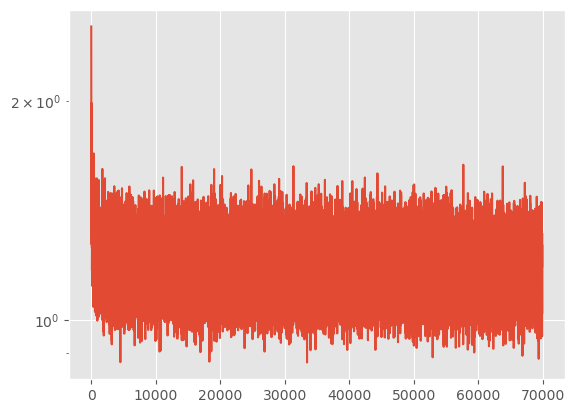

In [ ]:
plt.plot(np.array(losses_verbose).flatten())
plt.yscale('log')

In [ ]:
model.cpu()
torch.save(model.state_dict(), "./tmpmodel4.pt")


In [7]:
model.load_state_dict(torch.load("./tmpmodel4.pt"))

<All keys matched successfully>

In [8]:
with torch.no_grad():
    display(model(torch.rand(8, 2, 249)).shape)
    # display(model(torch.rand(8, 249, 2)).shape)

torch.Size([8, 2, 5, 1])

In [9]:
x = torch.rand(1, 2, 249)
torch.onnx.export(model, x, "model.onnx")

c:\Users\Abstract\mambaforge\envs\intel_dl\Lib\site-packages\torch\nn\modules\module.py:1527: UserWarning: The grad mode is detected as torch.no_grad() is NOT enabled. In this mode on XPU, please expect NO graph and fusion optimization will be applied. 
 (Triggered internally at C:/jenkins/workspace/IPEX-GPU-ARC770-Windows-Build/frameworks.ai.pytorch.ipex-gpu/csrc/gpu/jit/fusion_pass.cpp:829.)
  return forward_call(*args, **kwargs)
